### Project Overview
- You are assigned to fetch the total federal debts held by private investors. The data will be in units of Billions of Dollars, Not Seasonally Adjusted. The time frame will be Quarterly reported  beginning year 2000 to the recently reported june 9th 2020(q1 2020 reported). The data will be colleced from the Federal Reserve Bank of St. Louis cited below
- Using your knowledge of Recurrent Neural Networks forecast the Debt held by investors one quarter out. Based on your observation is the forcast resonable to use as a good indicator of what the debt held by private investors. If not, what would you suggest?

#### Suggested Citation: U.S. Department of the Treasury. Fiscal Service, Federal Debt Held by Private Investors
[FDHBPIN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/FDHBPIN, August 31, 2020.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Importing Data 

In [39]:
data = pd.read_csv("resources/fedDebtheldPrivateInvestors.csv", parse_dates=True, index_col="DATE")

In [40]:
data.columns= ["fed debt"]

Text(0.5, 1.0, 'Federal Debt held by Private Investors')

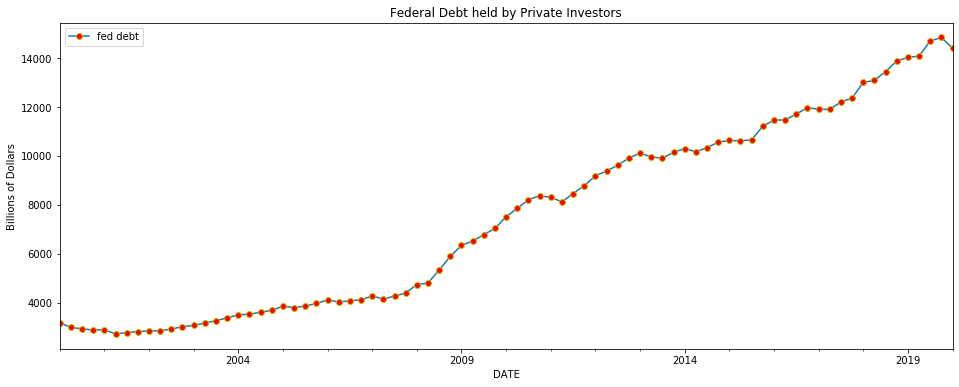

In [41]:
data.plot(figsize = (16,6), marker = "o", mfc = "red", mec = "y")
plt.ylabel("Billions of Dollars")
plt.title("Federal Debt held by Private Investors")

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2000-01-01 to 2020-01-01
Data columns (total 1 columns):
fed debt    81 non-null float64
dtypes: float64(1)
memory usage: 1.3 KB


### Summary
- The federal deby held by private investors has continue to increase within the 20 year period of our data set
- Data provides us with 81 quarters which we will use for our analysis
- we will need a siginificant amount of data to forecast this since we can see that there is no seasonality in the data.

### Data sampling to create model
 - Since we have 81 quarters we will take approsimately 30 quarters to be our testing sample below

In [43]:
test_sample = 30

In [44]:
test_index = len(data) - test_sample

In [45]:
test_index

51

## Setting testing and training data

In [46]:
train = data.iloc[:test_index]

In [47]:
test =data.iloc[test_index:]

In [48]:
test.shape

(30, 1)

In [49]:
train.shape

(51, 1)

#### Scaling the data to a nomal distribution 
- Will do this to punish any extrame values or outliers

In [50]:
from sklearn.preprocessing import MinMaxScaler

In [51]:
scalar = MinMaxScaler()

In [52]:
train_scaled = scalar.fit_transform(train)

In [53]:
test_scaled = scalar.transform(test)

## Length
- This is the number if quarters we are going to attempt to predict
- we will aim for 4 quarters 
- Since the model is mostly accurate in the first prediction, we will look at the first quarter predicitons as the target.

In [56]:
length = 4

### Time series generator

In [54]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [57]:
gen = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=1)

### Validation Generation

In [58]:
valid_gen = TimeseriesGenerator(test_scaled, test_scaled, length=4, batch_size=1)

## Early stopping 
- Adding early stopping to prevent overtraining of the model

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

In [60]:
stop = EarlyStopping(monitor="val_loss", mode = "min", patience=3)

## Network and Model 
- Will use a LSTM to prevent gradient Decay for beter learning and results
- number of features we are trying ot predict will be 1(value of rate)

In [61]:
n_features = 1 

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [63]:
model = Sequential()
model.add(LSTM(units = 200, activation ='relu', input_shape = (length, n_features)))
model.add(Dense(units = 1))
model.compile(loss = "mse", optimizer = "adam")

### Fitting model

In [64]:
model.fit_generator(gen, validation_data=valid_gen, epochs=10, callbacks=[stop])

Epoch 1/10
47/47 [==============================] - 10s 212ms/step - loss: 0.1152 - val_loss: 0.1330
Epoch 2/10
47/47 [==============================] - 10s 205ms/step - loss: 0.0095 - val_loss: 0.0496
Epoch 3/10
47/47 [==============================] - 9s 200ms/step - loss: 0.0026 - val_loss: 0.0095
Epoch 4/10
47/47 [==============================] - 11s 235ms/step - loss: 0.0018 - val_loss: 0.0294
Epoch 5/10
47/47 [==============================] - 10s 220ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 6/10
47/47 [==============================] - 10s 210ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 7/10
47/47 [==============================] - 9s 201ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 8/10
47/47 [==============================] - 9s 192ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 9/10
47/47 [==============================] - 10s 203ms/step - loss: 0.0017 - val_loss: 0.0149
Epoch 10/10
47/47 [==============================] - 11s 227ms/step - loss: 0.0016 - val_loss:

## Model  Performance
-  plotting the model performance on training
- model did pretty well in training where the loss was close to the predicitons
- This could be increased by increasing the Epohs during training

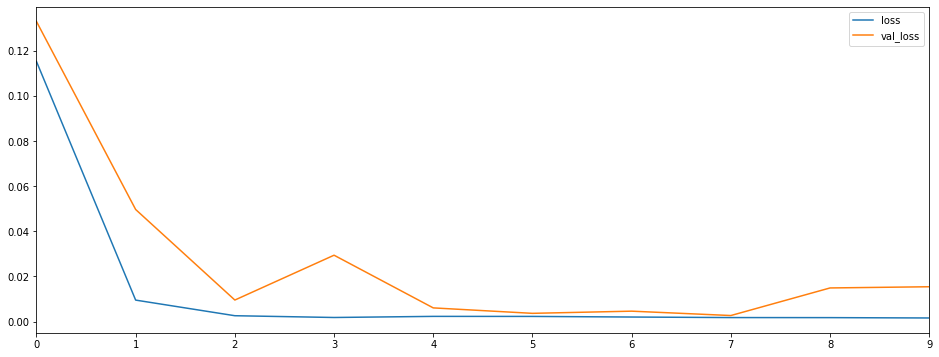

In [67]:
pd.DataFrame(model.history.history).plot(figsize = (16,6))

## Making Prediction
- Will use the model to make prediction of the first quarter out

In [68]:
predictions = []
batch = train_scaled[-length:]
current_batch = batch.reshape((1,length,n_features))

for x in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)b

In [99]:
train_scaled[-length:]

array([[0.87876986],
       [0.93702877],
       [0.96524475],
       [1.        ]])

## Predictions
- The predicitons we have are in a scaled format so we need to inverse this

In [70]:
predictions

[array([1.0559183], dtype=float32),
 array([1.103633], dtype=float32),
 array([1.1462926], dtype=float32),
 array([1.1958944], dtype=float32),
 array([1.2521982], dtype=float32),
 array([1.3076701], dtype=float32),
 array([1.3660395], dtype=float32),
 array([1.4311934], dtype=float32),
 array([1.5025421], dtype=float32),
 array([1.5793449], dtype=float32),
 array([1.6647477], dtype=float32),
 array([1.7613838], dtype=float32),
 array([1.8709854], dtype=float32),
 array([1.9966782], dtype=float32),
 array([2.1439307], dtype=float32),
 array([2.3194058], dtype=float32),
 array([2.532219], dtype=float32),
 array([2.7965157], dtype=float32),
 array([3.1343558], dtype=float32),
 array([3.580585], dtype=float32),
 array([4.1940455], dtype=float32),
 array([5.0809884], dtype=float32),
 array([6.445758], dtype=float32),
 array([8.712753], dtype=float32),
 array([12.829878], dtype=float32),
 array([20.987658], dtype=float32),
 array([37.962414], dtype=float32),
 array([73.21965], dtype=float32)

In [71]:
true_predictions = scalar.inverse_transform(predictions)

### True Predicitons 
- Will combine this with out test data to
- remeber we will only be paying attention to the first quarter out since this will be the most accurate

In [72]:
true_predictions

array([[  10005.05757914],
       [  10334.13639269],
       [  10628.35057783],
       [  10970.44422579],
       [  11358.76067886],
       [  11741.33925896],
       [  12143.90132389],
       [  12593.25430832],
       [  13085.33261805],
       [  13615.02569017],
       [  14204.03204079],
       [  14870.51159801],
       [  15626.41202917],
       [  16493.29043837],
       [  17508.86106968],
       [  18719.07788105],
       [  20186.80753784],
       [  22009.60950184],
       [  24339.62496738],
       [  27417.17864799],
       [  31648.09330559],
       [  37765.16084633],
       [  47177.70284958],
       [  62812.71693115],
       [  91207.70157928],
       [ 147470.27657013],
       [ 264541.77541199],
       [ 507703.88397217],
       [1023578.65175781],
       [2136482.82114258]])

### Combining True predicitons with the test data 

In [73]:
test["predictions"] = true_predictions

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
test

,fed debt,predictions
DATE,,
2012-10-01,9909.1,1.000506e+04
2013-01-01,10114.8,1.033414e+04
2013-04-01,9964.9,1.062835e+04
2013-07-01,9904.0,1.097044e+04
2013-10-01,10146.6,1.135876e+04
2014-01-01,10299.7,1.174134e+04
2014-04-01,10171.6,1.214390e+04
2014-07-01,10333.2,1.259325e+04
2014-10-01,10562.6,1.308533e+04


### Test vs true Predicitons 
- We can see that the model perform very well with making predicitons
- since our predictions are accurate it is safe to foreacast on the data that we have

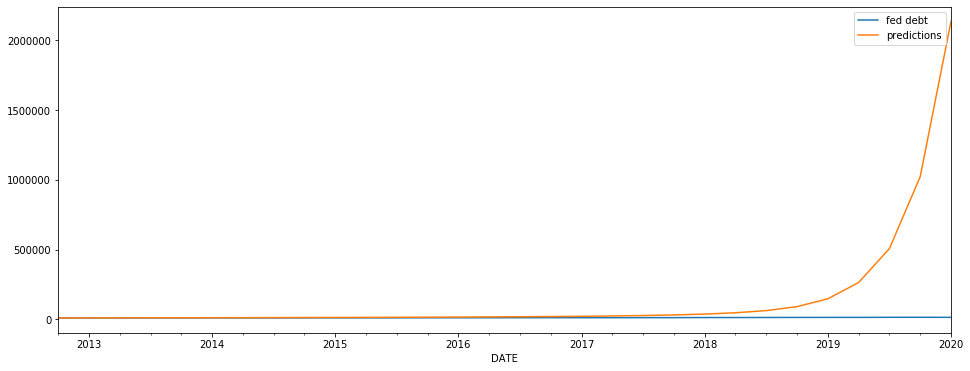

In [78]:
test.plot(figsize = (16,6))

### Forecasting
 - Based on the 20 years of data and using the model we just created, we will forcast the value of Total Debt held by prvate investors 4 quarters out. Though the above shows the model predictions were very accurate we will pay closer attention to the first month out
 - Will need to scale the entire data set and forecast 4 quarter

In [79]:
fullScaler = MinMaxScaler()

In [80]:
data_scaled = fullScaler.fit_transform(data)

In [82]:
forecast = []
period = length
batch = data_scaled[-length:]
curr_b = batch.reshape((1,length,n_features))

for i in range(period):
    current_pred = model.predict(curr_b)[0]
    forecast.append(current_pred)
    curr_b = np.append(curr_b[:,1:,:], [[current_pred]], axis=1)

In [83]:
forecast

[array([1.0930606], dtype=float32),
 array([1.1313249], dtype=float32),
 array([1.1622157], dtype=float32),
 array([1.2031733], dtype=float32)]

## inverse scale the forecast to get the true values

In [84]:
true_forecast = fullScaler.inverse_transform(forecast)

In [85]:
true_forecast

array([[15969.29225899],
       [16433.01317641],
       [16807.37596412],
       [17303.73666011]])

## Adding forecast to data plot
- will add the forcast values to the data plot
- paying closer attention to the first value

### Setting dates for forecast
- lets get the last quarter first, which we will add 4 quarters to

In [89]:
data.tail()

,fed debt
DATE,
2019-01-01,14028.9
2019-04-01,14078.4
2019-07-01,14695.8
2019-10-01,14841.5
2020-01-01,14407.2


In [92]:
dates = pd.date_range(start="2020-4-1", periods=period, freq="QS")

In [93]:
dates

DatetimeIndex(['2020-04-01', '2020-07-01', '2020-10-01', '2021-01-01'], dtype='datetime64[ns]', freq='QS-JAN')

### Creating Forecast DataFrame
- Will add the dates to the forecasted data 

In [94]:
forecast_Df = pd.DataFrame(true_forecast, columns=["forecast"], index=dates)

In [95]:
forecast_Df

,forecast
2020-04-01,15969.292259
2020-07-01,16433.013176
2020-10-01,16807.375964
2021-01-01,17303.736660


(199, 204)

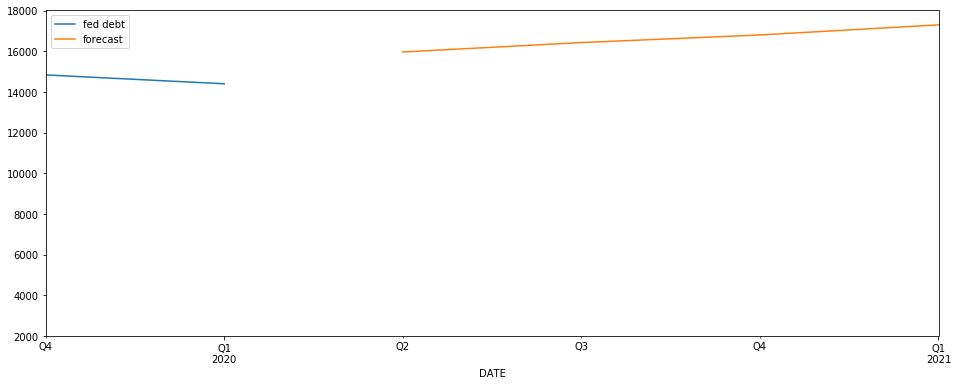

In [98]:
ax = data.plot(figsize = (16,6))
forecast_Df.plot(ax = ax)
plt.xlim("2019-10-01", "2021-01-01")